# A Comparison of COVID-19 Case Rates in New York City by Zip Code

### Introduction

New York City was one of the earliest hot spots of COVID-19 in the US. Given the rapid spread of the coronavirus in New York City, it would be illuminating to see how different types of neighborhoods differed in their COVID-19 case counts.

This project will first use machine learning to cluster New York City zip codes by type. Then, it will run a statistical analysis comparing COVID case rates among neighborhood clusters. Specifically, neighborhoods will be clustered using K-Means clustering, and then once the clusters are created, an ANOVA analysis on COVID-19 case rates will be used to compare different neighborhood clusters.

### Data 

The datasets used in this project include neighborhood data provided by FourSquare as well as COVID-19 caseload data provided by the New York City Department of Health and Mental Hygiene.

The COVID-19 caseload data is broken down by zip code, so neighborhood comparisons will be conducted on the basis of zip code areas. It includes total case count, case rate, death count, and death rate. All of these categories will be analyzed.

Because the COVID-19 caseload data is broken down by zip code, neighborhood data will also be broken down by zip code. A python geocoder library can be used to convert zip codes into geographical coordinates, which will then be used to collect venue data from FourSquare.

### Data Collection and Formatting

Before we begin, we should install and import the packages we will be using in this analysis.

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

import numpy as np

!python -m pip install geopy
from geopy.geocoders import Nominatim

!python -m pip install folium
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests
import json

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import scipy.stats as stats

!python -m pip install statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc

print('All packages imported!')

All packages imported!


Next, we will read in the dataset we will be using (note: certain cells containing sensitive information have been hidden).

In [2]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_293ea4e2a794436fa5b6674340277d7a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='yO9T91JKbRoQjoB1zI9SpWvG90vruB7sloKJJ7zS_UpE',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_293ea4e2a794436fa5b6674340277d7a.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-14dizc4k9wkpxe',Key='data-by-modzcta.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [3]:
nyc_data = pd.read_csv(body)
nyc_data.head()

,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,432,1833.38,23563.03,25,106.10,6.70,6444
1,10002,Chinatown/Lower East Side,Manhattan,1269,1653.30,76755.41,161,209.76,9.52,13333
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,519,964.65,53801.62,34,63.20,5.01,10357
3,10004,Financial District,Manhattan,39,1068.32,3650.61,1,27.39,5.58,699
4,10005,Financial District,Manhattan,86,1024.28,8396.11,2,23.82,5.17,1662


We will re-name the columns to be more usable.

In [4]:
nyc_data.columns = ['Zipcode', 'Neighborhood', 'Borough', 'Case Count', 'Case Rate', 'Pop', 'Death Count', 'Death Rate', 'Percent Positive', 'Tests']

Now, we can begin the process of gathering venue data.

The first step is to gather location data of each zip code.

In [5]:
# Generate a list of all zip codes:
zip_codes = nyc_data['Zipcode']

# Set up geolocator:
latitude = []
longitude = []

geolocator = Nominatim(user_agent = 'nyc_explorer')

# Input all zipcodes into geolocator:
for zipcode in zip_codes:
    loc = geolocator.geocode({'country': 'US', 'postalcode': zipcode})
    lat = loc[1][0]
    lng = loc[1][1]
    latitude.append(lat)
    longitude.append(lng)
    
#Create dataframe of zip codes and other relevant information
locations = pd.DataFrame({'Zipcode': zip_codes, 'Latitude': latitude, 'Longitude': longitude})
locations['Neighborhood'] = nyc_data['Neighborhood']
locations['Borough'] = nyc_data['Borough']
locations = locations[['Zipcode', 'Neighborhood', 'Borough', 'Latitude', 'Longitude']]
locations.head()

,Zipcode,Neighborhood,Borough,Latitude,Longitude
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,40.729825,-73.960752
1,10002,Chinatown/Lower East Side,Manhattan,40.722313,-73.987709
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,40.731587,-73.988514
3,10004,Financial District,Manhattan,40.700762,-74.013465
4,10005,Financial District,Manhattan,40.720705,-74.006674


Next, to get a general sense of what we're working with, we will generate a map of New York City with each neighborhood marked and color-coded by borough.

In [6]:
nycloc = geolocator.geocode('New York City')
nylat = nycloc[1][0]
nylng = nycloc[1][1]

map_boroughs = folium.Map(location = [nylat, nylng], zoom_start = 10)

# set color scheme for the clusters
x = np.arange(locations.Borough.unique().shape[0])
ys = [i + x + (i*x)**2 for i in range(locations.Borough.unique().shape[0])]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, borough in zip(locations['Latitude'], locations['Longitude'], locations['Zipcode'], locations['Borough']):
    label = folium.Popup(str(poi) + str(borough), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup=label,
        color=rainbow[locations.Borough.unique().tolist().index(borough)],
        fill=True,
        fill_color=rainbow[locations.Borough.unique().tolist().index(borough)],
        fill_opacity=0.7).add_to(map_boroughs)
       
map_boroughs

Now, we can begin the process of gathering venue data from FourSquare.

First, we set up FourSquare credentials (this cell is hidden).

In [7]:
CLIENT_ID = '4LSTK2PBRKJDQFZM3BKK4OYFFK5YSUYX1T3WNFYSDWY2QYC4' # your Foursquare ID
CLIENT_SECRET = 'VNS3SMLQ3E2ES3ZUD03AJQQ1BLPHZPK3DSGSYTV0TRCNXZRU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Next, we can set up a couple of functions that we will use to streamline the process.

In [8]:
# This function returns a dataframe listing the most frequent venues of each zip code.
def CommonVenuesDf(df, num_top_venues = 10):
    columns = ['Zipcode']
    for ind in np.arange(num_top_venues):
        columns.append('Most common venue: {}'.format(ind + 1))
    venues_sorted = pd.DataFrame(columns = columns)
    
    venues_sorted['Zipcode'] = df['Zipcode']
    
    for ind in np.arange(df.shape[0]):
        venues_sorted.iloc[ind, 1:] = df.iloc[ind, 1:].sort_values(ascending = False).index.values[0:num_top_venues]
    
    return venues_sorted

In [9]:
# This function creates a plot of the sum of square distances for different values of k (number of clusters) 
# when running a k-means cluster analysis on the dataset to be used in an elbow analysis to determine optimal
# number of clusters.

def elbow(df, maxK = 20):
    ssd = []
    K = range(1, min(maxK, df.shape[0]))
    for k in K:
        km = KMeans(n_clusters = k, random_state = 42)
        km = km.fit(df.drop('Zipcode', 1))
        ssd.append(km.inertia_)
    dfElbow = plt.plot(K, ssd, 'bx-')
    
    return dfElbow

In [10]:
# This function creates a dataframe that includes the cluster label for the zip code.
def addClusterLabels(groupedDf, sortedDf, locationDf, kclusters):
    kmeans = KMeans(n_clusters = kclusters, random_state = 42).fit(groupedDf.drop('Zipcode', 1))
    sortedClone = sortedDf.copy()
    
    sortedClone.insert(0, 'Cluster Labels', kmeans.labels_)

    merged = locationDf

    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    merged = merged.join(sortedClone.set_index('Zipcode'), on = 'Zipcode')

    return merged

In [11]:
#This function maps and color codes each zip code by cluster.
def clusterMap(df):

    clusterMap = folium.Map(location = [nylat, nylng], zoom_start = 10)

    # set color scheme for the clusters
    x = np.arange(max(df['Cluster Labels']))
    ys = [i + x + (i*x)**2 for i in range(max(df['Cluster Labels']))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Zipcode'], df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(clusterMap)

    return clusterMap

#### Initial Data Observation

Now, let us gather the venue data for all of New York City.

In [12]:
# This will create a dataframe of the frequency of each venue type for each zip code.

radius = 500 
codes = locations['Zipcode']
latitudes = locations['Latitude']
longitudes = locations['Longitude']

venues_list = []
for code, lat, lng in zip(codes, latitudes, longitudes):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        100)

    # Make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # Return only relevant information for each nearby venue
    venues_list.append([(
        code, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Zipcode', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

venues_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix = '', prefix_sep = '')
venues_onehot['Zipcode'] = nearby_venues['Zipcode']
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[: -1])
venues_onehot = venues_onehot[fixed_columns]

nyc_grouped = venues_onehot.groupby('Zipcode').mean().reset_index()

In [13]:
nyc_grouped.head()

,Zipcode,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Amphitheater,Antique Shop,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.014286,...,0.0,0.0,0.0,0.014286,0.014286,0.014286,0.0,0.0,0.042857,0.0
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.000000,...,0.0,0.0,0.0,0.010000,0.020000,0.030000,0.0,0.0,0.000000,0.0
2,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.010000,0.020000,0.0,0.0,0.020000,0.0
3,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.000000,...,0.0,0.0,0.0,0.010000,0.020000,0.020000,0.0,0.0,0.020000,0.0


In [14]:
# This will create a dataframe that lists the most common types of venue for each zip code:
nyc_sorted = CommonVenuesDf(nyc_grouped)
nyc_sorted.head()

,Zipcode,Most common venue: 1,Most common venue: 2,Most common venue: 3,Most common venue: 4,Most common venue: 5,Most common venue: 6,Most common venue: 7,Most common venue: 8,Most common venue: 9,Most common venue: 10
0,10001,Bar,Cocktail Bar,Scenic Lookout,Yoga Studio,Coffee Shop,French Restaurant,Furniture / Home Store,Pizza Place,Beach,Tea Room
1,10002,Mexican Restaurant,Italian Restaurant,Cocktail Bar,Coffee Shop,Sandwich Place,Pizza Place,Art Gallery,French Restaurant,Bakery,Wine Shop
2,10003,Japanese Restaurant,Dessert Shop,Ice Cream Shop,Grocery Store,Pizza Place,Bar,Indie Theater,Mediterranean Restaurant,Park,Vegetarian / Vegan Restaurant
3,10004,Mexican Restaurant,Boat or Ferry,Bar,Cocktail Bar,Heliport,Park,Seafood Restaurant,Donut Shop,Farmers Market,Lebanese Restaurant
4,10005,Hotel,French Restaurant,Cocktail Bar,Coffee Shop,Boutique,Spa,Café,Art Gallery,Men's Store,Bakery


Now, to determine the optimal number of clusters for the KMeans cluster analysis, we run the elbow function.

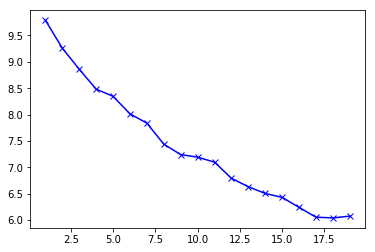

In [15]:
elbow(nyc_grouped)

There are multiple possible candidates for elbow points. Given the data set's size, we will choose a k value of 9.

We can now run the kMeans analysis and take a look at the results.

In [16]:
# Run the kMeans analysis and add the cluster labels to a dataframe.

nyc_merged = addClusterLabels(nyc_grouped, nyc_sorted, locations, 9)

In [17]:
nyc_merged.head()

,Zipcode,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,Most common venue: 1,Most common venue: 2,Most common venue: 3,Most common venue: 4,Most common venue: 5,Most common venue: 6,Most common venue: 7,Most common venue: 8,Most common venue: 9,Most common venue: 10
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,40.729825,-73.960752,1,Bar,Cocktail Bar,Scenic Lookout,Yoga Studio,Coffee Shop,French Restaurant,Furniture / Home Store,Pizza Place,Beach,Tea Room
1,10002,Chinatown/Lower East Side,Manhattan,40.722313,-73.987709,1,Mexican Restaurant,Italian Restaurant,Cocktail Bar,Coffee Shop,Sandwich Place,Pizza Place,Art Gallery,French Restaurant,Bakery,Wine Shop
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,40.731587,-73.988514,1,Japanese Restaurant,Dessert Shop,Ice Cream Shop,Grocery Store,Pizza Place,Bar,Indie Theater,Mediterranean Restaurant,Park,Vegetarian / Vegan Restaurant
3,10004,Financial District,Manhattan,40.700762,-74.013465,1,Mexican Restaurant,Boat or Ferry,Bar,Cocktail Bar,Heliport,Park,Seafood Restaurant,Donut Shop,Farmers Market,Lebanese Restaurant
4,10005,Financial District,Manhattan,40.720705,-74.006674,1,Hotel,French Restaurant,Cocktail Bar,Coffee Shop,Boutique,Spa,Café,Art Gallery,Men's Store,Bakery


In [18]:
# Generate a cluster map

nyc_cluster_map = clusterMap(nyc_merged)
nyc_cluster_map

The above cluster map reveals that an entire city-wide analysis may not be as illuminating because Manhattan neighborhoods seem quite distinct from neighborhoods outside of Manhattan. Therefore, it may be more illuminating to run this analysis on two subsets of data: neighborhoods in Manhattan and neighborhoods outside of Manhattan. 

First, we must split our data

In [19]:
# Separate data set into Manhattan and not Manhattan
manhattan = locations[locations['Borough'] == 'Manhattan']
notManhattan = locations[locations['Borough'] != 'Manhattan']

# Generate zip code lists for the new dataframes:
manhattan_zip = manhattan['Zipcode'].values.tolist()
notManhattan_zip = notManhattan['Zipcode'].values.tolist()

We can now run the above analysis on our two new datasets to generate new cluster maps.

In [20]:
# Create the "grouped" dataframes
manhattan_grouped = nyc_grouped[nyc_grouped['Zipcode'].isin(manhattan_zip)]
notManhattan_grouped = nyc_grouped[nyc_grouped['Zipcode'].isin(notManhattan_zip)]

# Create the "sorted" dataframes
manhattan_sorted = CommonVenuesDf(manhattan_grouped)
notManhattan_sorted = CommonVenuesDf(notManhattan_grouped)

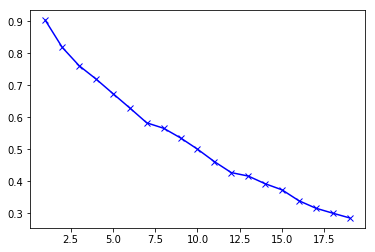

In [21]:
#Create the elbow graph for Manhattan zip codes
elbow(manhattan_grouped)

In [22]:
# From the above plot, we choose a k value of 5
# Create the dataframe for Manhattan zip codes that includes cluster labels
manhattan_merged = addClusterLabels(manhattan_grouped, manhattan_sorted, manhattan, 5)

# Generate the cluster map for Manhattan zip codes
manhattan_cluster_map = clusterMap(manhattan_merged)
manhattan_cluster_map

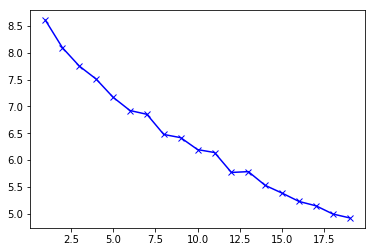

In [23]:
#Create the elbow graph for non-Manhattan zip codes
elbow(notManhattan_grouped)

In [24]:
# From the above plot, we choose a k value of 8
# Create the dataframe for Manhattan zip codes that includes cluster labels
notManhattan_merged = addClusterLabels(notManhattan_grouped, notManhattan_sorted, notManhattan, 8)

# Generate the cluster map for Manhattan zip codes
notManhattan_cluster_map = clusterMap(notManhattan_merged)
notManhattan_cluster_map

Another metric that may be useful to us is the number of neighborhoods in each cluster. Since we will be running an ANOVA test, we may want to exclude clusters that contain very few neighborhoods.

In [25]:
# How many neighborhoods are in each cluster in Manhattan?
manhattan_merged.groupby('Cluster Labels').nunique()

,Zipcode,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,Most common venue: 1,Most common venue: 2,Most common venue: 3,Most common venue: 4,Most common venue: 5,Most common venue: 6,Most common venue: 7,Most common venue: 8,Most common venue: 9,Most common venue: 10
Cluster Labels,,,,,,,,,,,,,,,,
0,6,5,1,6,6,1,3,4,6,5,5,6,6,5,6,6
1,19,17,1,19,19,1,9,13,12,12,14,16,14,15,15,16
2,4,2,1,4,4,1,3,3,3,4,4,4,4,4,4,4
3,14,13,1,14,14,1,6,12,9,13,14,13,12,12,14,14
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [26]:
# How many neighborhoods are in each cluster outside of Manhattan?
notManhattan_merged.groupby('Cluster Labels').nunique()

,Zipcode,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,Most common venue: 1,Most common venue: 2,Most common venue: 3,Most common venue: 4,Most common venue: 5,Most common venue: 6,Most common venue: 7,Most common venue: 8,Most common venue: 9,Most common venue: 10
Cluster Labels,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,53,53,4,53,53,1,30,29,34,37,39,39,44,44,42,40
2,8,8,3,8,8,1,4,6,7,7,5,7,7,8,8,8
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,11,11,3,11,11,1,5,10,8,10,10,10,10,8,9,11
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,12,12,4,12,12,1,7,11,9,12,12,11,11,11,12,12
7,46,45,4,46,46,1,18,21,32,28,33,31,37,33,30,35


We can now add the cluster labels back into the original dataset that includes COVID data.

First, we should separate the original dataset into Manhattan and not Manhattan datasets.

In [27]:
manhattan_data = nyc_data.loc[nyc_data['Borough'] == 'Manhattan']
notManhattan_data = nyc_data.loc[nyc_data['Borough'] != 'Manhattan']

Next, we add the cluster labels into the dataset

In [28]:
manhattan_covid = pd.merge(manhattan_data, manhattan_merged, on = 'Zipcode')
notManhattan_covid = pd.merge(notManhattan_data, notManhattan_merged, on = 'Zipcode')

The only relevant data we will need from our dataset is the zipcode as an index, the COVID-19 data, and the cluster label.

In [29]:
manhattan_covid.columns

Index(['Zipcode', 'Neighborhood_x', 'Borough_x', 'Case Count', 'Case Rate',
       'Pop', 'Death Count', 'Death Rate', 'Percent Positive', 'Tests',
       'Neighborhood_y', 'Borough_y', 'Latitude', 'Longitude',
       'Cluster Labels', 'Most common venue: 1', 'Most common venue: 2',
       'Most common venue: 3', 'Most common venue: 4', 'Most common venue: 5',
       'Most common venue: 6', 'Most common venue: 7', 'Most common venue: 8',
       'Most common venue: 9', 'Most common venue: 10'],
      dtype='object')

In [30]:
# Select only relevant columns
manhattan_covid = manhattan_covid[['Zipcode', 'Cluster Labels', 'Case Count', 'Case Rate', 'Pop', 'Death Count', 'Death Rate', 'Percent Positive', 'Tests']].reset_index(drop = True)
notManhattan_covid = notManhattan_covid[['Zipcode', 'Cluster Labels', 'Case Count', 'Case Rate', 'Pop', 'Death Count', 'Death Rate', 'Percent Positive', 'Tests']].reset_index(drop = True)

In [31]:
# Examine the resulting Manhattan dataframe
manhattan_covid.head()

,Zipcode,Cluster Labels,Case Count,Case Rate,Pop,Death Count,Death Rate,Percent Positive,Tests
0,10001,1,432,1833.38,23563.03,25,106.10,6.70,6444
1,10002,1,1269,1653.30,76755.41,161,209.76,9.52,13333
2,10003,1,519,964.65,53801.62,34,63.20,5.01,10357
3,10004,3,39,1068.32,3650.61,1,27.39,5.58,699
4,10005,1,86,1024.28,8396.11,2,23.82,5.17,1662


In [32]:
# Examine the resulting non-Manhattan dataframe
notManhattan_covid.head()

,Zipcode,Cluster Labels,Case Count,Case Rate,Pop,Death Count,Death Rate,Percent Positive,Tests
0,10301,1,1289,3253.94,39613.55,106,267.59,15.52,8307
1,10302,7,681,3627.36,18773.99,32,170.45,19.56,3481
2,10303,6,932,3552.96,26231.66,47,179.17,17.52,5321
3,10304,6,1483,3493.63,42448.71,182,428.75,16.48,9001
4,10305,6,1343,3155.47,42560.99,80,187.97,16.33,8223


With our data collected and properly formatted, we can now conduct the statistical analysis.

### Statistical Analysis

#### ANOVA Test

Since the actual case and death counts depend on population, which may differ among neighborhoods, the more relevant variables are the case and death rates. We will therefore run an ANOVA test on differences in case and death rates among different neighborhood clusters for Manhattan and the rest of New York City.

First, we will drop any clusters with fewer than five neighborhoods from our data set to give us more confidence in the precision of our analysis.

In [33]:
# Drop clusters with fewer than 5 observations from the data.

countsM = manhattan_covid['Cluster Labels'].value_counts()
manhattan_abridged = manhattan_covid[manhattan_covid['Cluster Labels'].isin(countsM[countsM >= 5].index)]

countsNM = notManhattan_covid['Cluster Labels'].value_counts()
notManhattan_abridged = notManhattan_covid[notManhattan_covid['Cluster Labels'].isin(countsNM[countsNM >= 5].index)]

Now, we can examine our data to get a sense of what case rates and death rates look like for our neighborhood clusters.

In [34]:
# Look at mean data for Manhattan
manhattan_abridged.groupby('Cluster Labels').mean()[['Case Rate', 'Death Rate']]

,Case Rate,Death Rate
Cluster Labels,,
0,1224.060000,107.926667
1,1278.781579,100.726842
3,2154.347857,205.475000


In [35]:
# Look at mean data for outside of Manhattan
notManhattan_abridged.groupby('Cluster Labels').mean()[['Case Rate', 'Death Rate']]

,Case Rate,Death Rate
Cluster Labels,,
1,2428.391887,211.569434
2,2781.391250,228.296250
4,3355.629091,299.304545
6,2980.777500,230.997500
7,3077.333478,252.146087


Now, we can run our analysis.

First, we will look at how the case rate differs among neighborhood clusters in Manhattan.

Before we run the ANOVA test, we can look at the boxplot of our data.

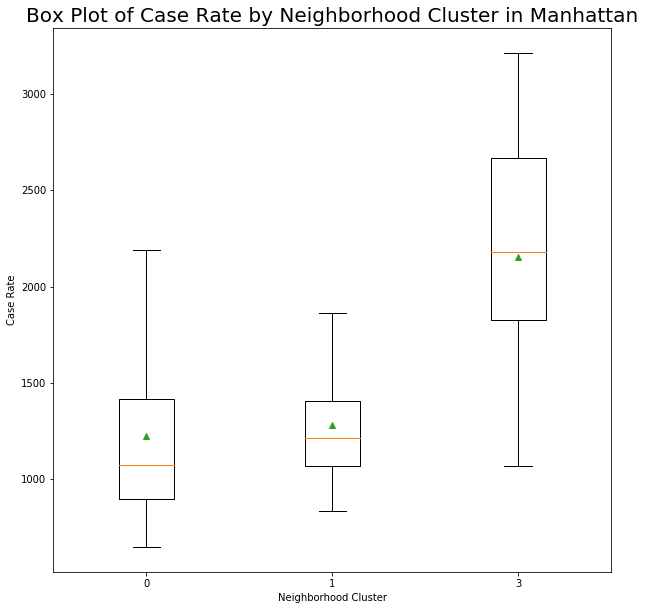

In [36]:
# Manhattan case rate box plot
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Case Rate by Neighborhood Cluster in Manhattan", fontsize= 20)
ax.set

data = [manhattan_abridged['Case Rate'][manhattan_abridged['Cluster Labels'] == 0],
        manhattan_abridged['Case Rate'][manhattan_abridged['Cluster Labels'] == 1],
        manhattan_abridged['Case Rate'][manhattan_abridged['Cluster Labels'] == 3]]

ax.boxplot(data,
           labels= ['0', '1', '3'],
           showmeans= True)

plt.xlabel("Neighborhood Cluster")
plt.ylabel("Case Rate")

plt.show()

Now, we run the ANOVA test.

In [37]:
# Run the ANOVA test on case rate among clusters in Manhattan.
manhattan_case_rate_model = ols('manhattan_abridged[\'Case Rate\'] ~ C(manhattan_abridged[\'Cluster Labels\'])', data = manhattan_abridged).fit()
manhattan_case_rate_aov = sm.stats.anova_lm(manhattan_case_rate_model, typ = 2)
manhattan_case_rate_aov

,sum_sq,df,F,PR(>F)
C(manhattan_abridged['Cluster Labels']),7.101484e+06,2.0,15.035075,0.000018
Residual,8.501901e+06,36.0,NaN,NaN


The above indicates a statistically significant difference in mean case rate between neighborhood clusters.

Before we can be confident in our conclusion, we should check that the assumptions for normality and variance are met.

In [38]:
# Shapiro test for normality condition:
stats.shapiro(manhattan_case_rate_model.resid)

(0.9716246128082275, 0.42063969373703003)

The above indicates that residuals are roughly normally distributed. To illustrate this, we will plot the residuals.

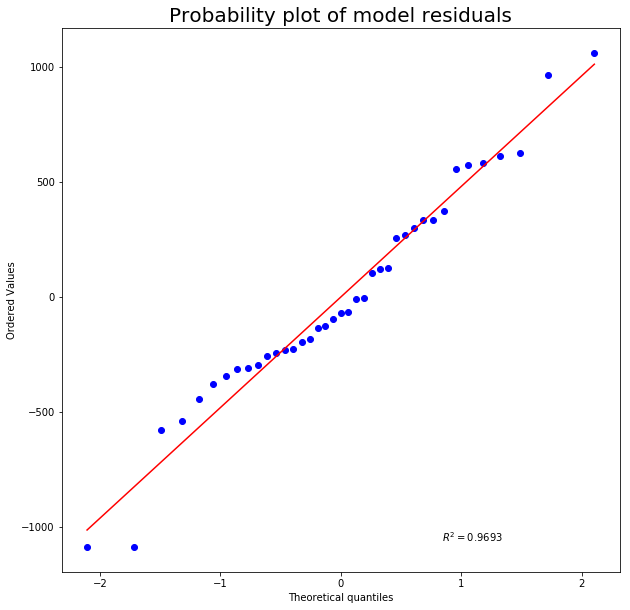

In [39]:
# Residual Plot
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(manhattan_case_rate_model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

Next, we check for homogeneity of variance.

In [40]:
# Levene test for homogeneity of variance.
stats.levene(manhattan_abridged['Case Rate'][manhattan_abridged['Cluster Labels'] == 0],
             manhattan_abridged['Case Rate'][manhattan_abridged['Cluster Labels'] == 1],
             manhattan_abridged['Case Rate'][manhattan_abridged['Cluster Labels'] == 3])

LeveneResult(statistic=5.4994192945081855, pvalue=0.008239042548523826)

The above indicates that variance is not homogenous. Therefore, we must proceed cautiously.

With some of our conditions unmet, we can only cautiously conclude that there is a statistically significant difference in COVID case rates among neighborhood clusters in Manhattan. To further delve into what these differences are, we can run a Tukey HSD test on the data.

In [41]:
# Tukey HSD
manhattan_case_rate_tukey = mc.MultiComparison(manhattan_abridged['Case Rate'], manhattan_abridged['Cluster Labels'])
manhattan_case_rate_tukey.tukeyhsd().summary()

group1,group2,meandiff,lower,upper,reject
0,1,54.7216,-501.4684,610.9116,False
0,3,930.2879,350.7511,1509.8246,True
1,3,875.5663,457.2336,1293.8989,True


The Tukey HSD test demonstrates that there is only a significant difference in case rates between cluster 3 and other clusters. From the earlier table of mean case rates in neighborhood clusters, we can conclude that neighborhoods in cluster 3 had on average significnatly higher rates of COVID than other neighborhoods, with the caveat that the variance among clusters is not homogenous, which means we cannot be fully confident in our results.

We now run the same analysis on COVID death rates in Manhattan.

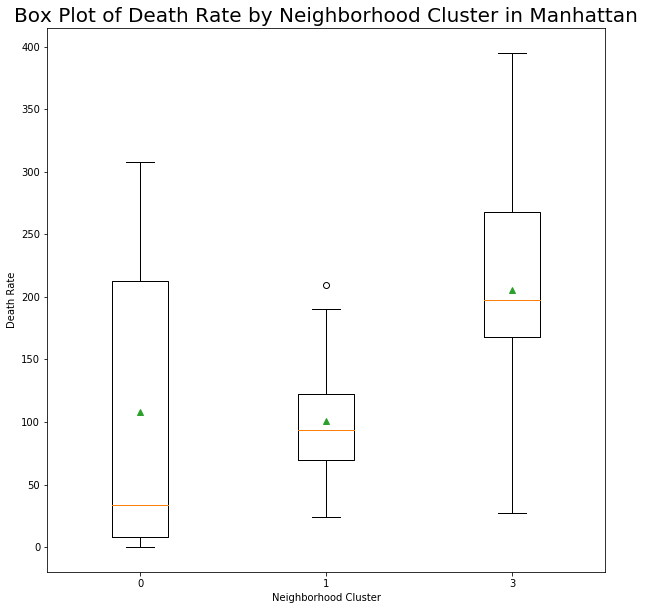

In [43]:
# Manhattan death rate box plot
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Death Rate by Neighborhood Cluster in Manhattan", fontsize= 20)
ax.set

data = [manhattan_abridged['Death Rate'][manhattan_abridged['Cluster Labels'] == 0],
        manhattan_abridged['Death Rate'][manhattan_abridged['Cluster Labels'] == 1],
        manhattan_abridged['Death Rate'][manhattan_abridged['Cluster Labels'] == 3]]

ax.boxplot(data,
           labels= ['0', '1', '3'],
           showmeans= True)

plt.xlabel("Neighborhood Cluster")
plt.ylabel("Death Rate")

plt.show()

In [44]:
# Run the ANOVA test on death rate among clusters in Manhattan.
manhattan_death_rate_model = ols('manhattan_abridged[\'Death Rate\'] ~ C(manhattan_abridged[\'Cluster Labels\'])', data = manhattan_abridged).fit()
manhattan_death_rate_aov = sm.stats.anova_lm(manhattan_death_rate_model, typ = 2)
manhattan_death_rate_aov

,sum_sq,df,F,PR(>F)
C(manhattan_abridged['Cluster Labels']),95482.701004,2.0,6.593173,0.003633
Residual,260677.004094,36.0,NaN,NaN


There is a statistically significant difference in death rates among neighborhood clusters in Manhattan.

In [45]:
# Shapiro test for normality condition:
stats.shapiro(manhattan_death_rate_model.resid)

(0.968424379825592, 0.33549124002456665)

Residuals are normally distributed.

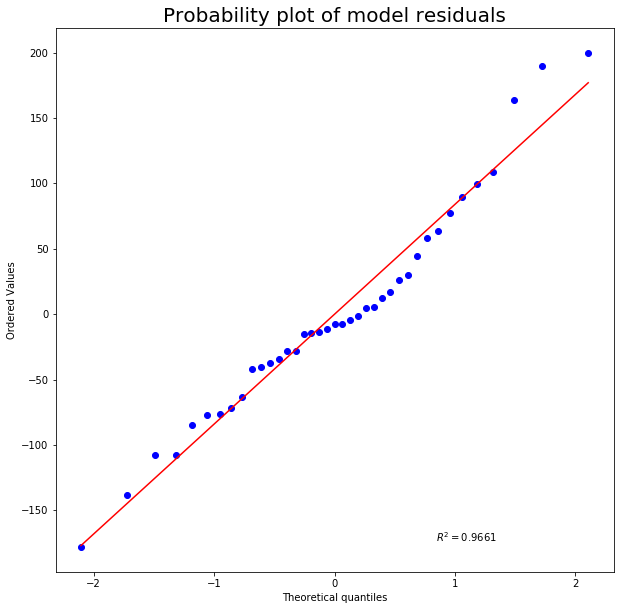

In [46]:
# Residual Plot
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(manhattan_death_rate_model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

In [47]:
# Levene test for homogeneity of variance.
stats.levene(manhattan_abridged['Death Rate'][manhattan_abridged['Cluster Labels'] == 0],
             manhattan_abridged['Death Rate'][manhattan_abridged['Cluster Labels'] == 1],
             manhattan_abridged['Death Rate'][manhattan_abridged['Cluster Labels'] == 3])

LeveneResult(statistic=2.8602072410286206, pvalue=0.07033475109435318)

Variance is homogeneous.

In [48]:
# Tukey HSD
manhattan_deat_rate_tukey = mc.MultiComparison(manhattan_abridged['Death Rate'], manhattan_abridged['Cluster Labels'])
manhattan_deat_rate_tukey.tukeyhsd().summary()

group1,group2,meandiff,lower,upper,reject
0,1,-7.1998,-104.5903,90.1907,False
0,3,97.5483,-3.9302,199.0269,False
1,3,104.7482,31.4969,177.9994,True


Based on the above analysis, we can only conclude that there is a statistically significant difference in death rates between clusters 1 and 3.

Now, we can run the same analysis on neighborhood clusters outside of Manhattan.

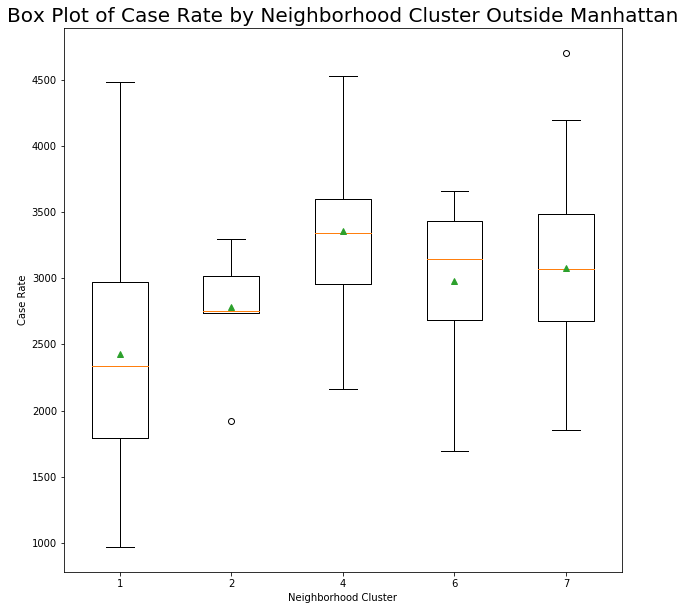

In [49]:
# Outside Manhattan case rate box plot
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Case Rate by Neighborhood Cluster Outside Manhattan", fontsize= 20)
ax.set

data = [notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 1],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 2],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 4],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 6],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 7]]

ax.boxplot(data,
           labels= ['1', '2', '4', '6', '7'],
           showmeans= True)

plt.xlabel("Neighborhood Cluster")
plt.ylabel("Case Rate")

plt.show()

In [50]:
# Run the ANOVA test on case rate among clusters in Manhattan.
notManhattan_case_rate_model = ols('notManhattan_abridged[\'Case Rate\'] ~ C(notManhattan_abridged[\'Cluster Labels\'])', data = notManhattan_abridged).fit()
notManhattan_case_rate_aov = sm.stats.anova_lm(notManhattan_case_rate_model, typ = 2)
notManhattan_case_rate_aov

,sum_sq,df,F,PR(>F)
C(notManhattan_abridged['Cluster Labels']),1.463687e+07,4.0,6.91829,0.000046
Residual,6.611490e+07,125.0,NaN,NaN


There is a statistically significant difference in case rates outside of Manhattan.

In [51]:
# Shapiro test for normality condition:
stats.shapiro(notManhattan_case_rate_model.resid)

(0.982252836227417, 0.08742653578519821)

Residuals are normally distributed.

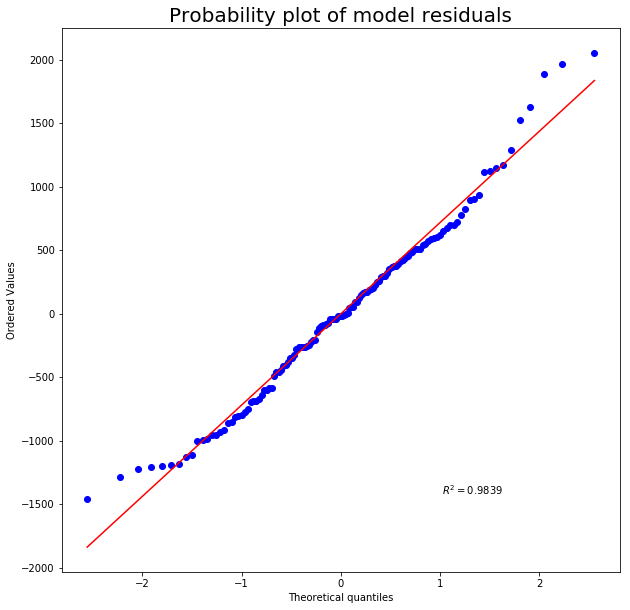

In [52]:
# Residual Plot
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(notManhattan_case_rate_model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residuals", fontsize= 20)
ax.set

plt.show()

In [53]:
# Levene test for homogeneity of variance.
stats.levene(notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 1],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 2],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 4],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 6],
        notManhattan_abridged['Case Rate'][notManhattan_abridged['Cluster Labels'] == 7])

LeveneResult(statistic=2.168464922799195, pvalue=0.07633709738024236)

Variance is homogenous.

In [54]:
# Tukey HSD
notManhattan_case_rate_tukey = mc.MultiComparison(notManhattan_abridged['Case Rate'], notManhattan_abridged['Cluster Labels'])
notManhattan_case_rate_tukey.tukeyhsd().summary()

group1,group2,meandiff,lower,upper,reject
1,2,352.9994,-410.5813,1116.5801,False
1,4,927.2372,260.2329,1594.2416,True
1,6,552.3856,-91.1922,1195.9634,False
1,7,648.9416,243.2708,1054.6123,True
2,4,574.2378,-361.186,1509.6617,False
2,6,199.3863,-719.4801,1118.2526,False
2,7,295.9422,-475.2203,1067.1048,False
4,6,-374.8516,-1215.1817,465.4785,False
4,7,-278.2956,-953.9664,397.3751,False
6,7,96.556,-555.9995,749.1114,False


We can only conclude that case rates in clusters 4 and 7 differ from those in cluster 1, and there are no other statistically significant differences in case rates among clusters.

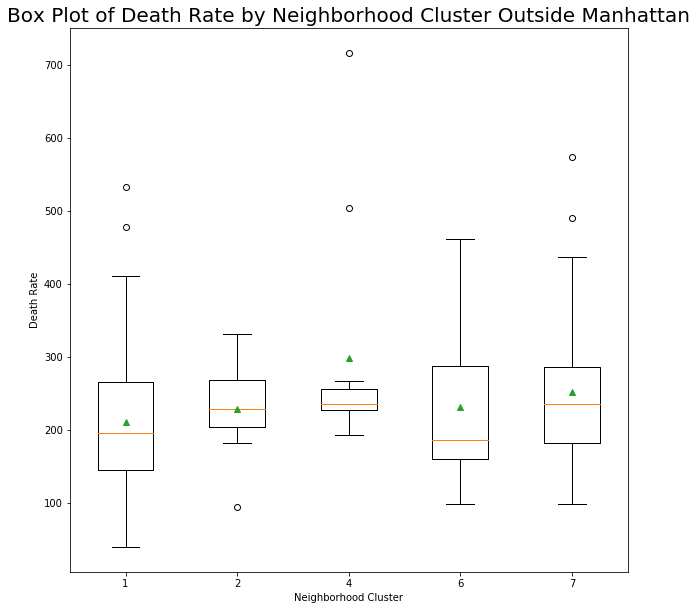

In [55]:
# Outside Manhattan death rate box plot
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Death Rate by Neighborhood Cluster Outside Manhattan", fontsize= 20)
ax.set

data = [notManhattan_abridged['Death Rate'][notManhattan_abridged['Cluster Labels'] == 1],
        notManhattan_abridged['Death Rate'][notManhattan_abridged['Cluster Labels'] == 2],
        notManhattan_abridged['Death Rate'][notManhattan_abridged['Cluster Labels'] == 4],
        notManhattan_abridged['Death Rate'][notManhattan_abridged['Cluster Labels'] == 6],
        notManhattan_abridged['Death Rate'][notManhattan_abridged['Cluster Labels'] == 7]]

ax.boxplot(data,
           labels= ['1', '2', '4', '6', '7'],
           showmeans= True)

plt.xlabel("Neighborhood Cluster")
plt.ylabel("Death Rate")

plt.show()

In [56]:
# Run the ANOVA test on case rate among clusters in Manhattan.
notManhattan_death_rate_model = ols('notManhattan_abridged[\'Death Rate\'] ~ C(notManhattan_abridged[\'Cluster Labels\'])', data = notManhattan_abridged).fit()
notManhattan_death_rate_aov = sm.stats.anova_lm(notManhattan_case_rate_model, typ = 2)
notManhattan_death_rate_aov

,sum_sq,df,F,PR(>F)
C(notManhattan_abridged['Cluster Labels']),1.463687e+07,4.0,6.91829,0.000046
Residual,6.611490e+07,125.0,NaN,NaN


The data indicates that death rates do not differ significantly among neighborhood clusters outside of Manhattan.

For the sake of further analysis, we run the Tukey HSD on this data.

In [57]:
# Tukey HSD
notManhattan_death_rate_tukey = mc.MultiComparison(notManhattan_abridged['Death Rate'], notManhattan_abridged['Cluster Labels'])
notManhattan_death_rate_tukey.tukeyhsd().summary()

group1,group2,meandiff,lower,upper,reject
1,2,16.7268,-95.1026,128.5562,False
1,4,87.7351,-9.9503,185.4205,False
1,6,19.4281,-74.8264,113.6826,False
1,7,40.5767,-18.8354,99.9887,False
2,4,71.0083,-65.9882,208.0048,False
2,6,2.7013,-131.8703,137.2728,False
2,7,23.8498,-89.0899,136.7896,False
4,6,-68.307,-191.3767,54.7626,False
4,7,-47.1585,-146.1131,51.7962,False
6,7,21.1486,-74.4207,116.7179,False


As expected, the Tukey HSD similarly does not indicate any significant difference in death rates between any two clusters.

### Conclusions and Cautions

From our above analysis, we can conclude that:
1. Within Manhattan, neighborhood cluster 3 has a significantly higher case rate than any other neighborhood, with the caveat that variances among clusters was not homogenous and therefore this conclusion may be spurious.
2. Within Manhattan, death rates only differed between neighborhood clusters 1 and 3.
3. Outside of Manhattan, case rates differed only between neighborhood cluster 1 and neighborhood clusters 4 and 7.
4. Outside of Manhattan, there was no significant difference in death rates among neighborhood clusters.

The usefulness of these conclusions is limited for several reasons.
Firstly, the nature of the K-means clustering algorithm to form the neighborhood clusters is opaque by nature and, even having concluded some differences in case and death rates, the causes of these differences are difficult to elucidate. For example, a visual examination of the neighborhood cluster map of Manhattan shows a geographical correlation among neighborhood clusters, so perhaps any differences in case and death rates is a result of geography. Or, perhaps certain neighborhoods are home to certain venues due to the average income levels of residents of that neighborhood, and therefore any differences in case and death rates is the result of income correlations. There is no way to tell.

Secondly, due to the random nature of the K-means clustering algorithm, it is very likely that different clusters may result in different conclusions drawn from the ANOVA and Tukey tests.

Finally, the data set we are working with is somewhat limited. Some neighborhood clusters have very few data points, which means we cannot be confident in our conclusions.